In [1]:
import numpy as np
from dreye.algebra.filtering import Filter1D
import matplotlib.pyplot as plt

In [2]:
arr = np.array([100]*10+[0] + [100] * 10 + [0] + [100]*10)

In [3]:
window = 9

In [4]:
lfilter = Filter1D('boxcar', window)

In [5]:
start_idx, end_idx = int(np.floor((window-1)/2)), int(np.ceil((window-1)/2))

In [6]:
start_idx, end_idx

(4, 4)

In [7]:
new_arr = np.hstack([
    np.array([100] * (start_idx)),
    arr, 
    np.array([100] * (end_idx)),
])

In [8]:
arr_filt = lfilter(new_arr, axis=-1, mode='valid')
arr_filt.shape, arr.shape

((32,), (32,))

In [9]:
from dreye.core import Signal

In [10]:
t = np.arange(-5, 5, 0.01)
a = np.array([3, 4, 5])
phase = np.array([0.1, -0.5, 1]) * np.pi

x = a[None, :] * np.sin(t[:, None] + phase[None, :])

x_noise = x + np.random.normal(0, 0.7, size=x.shape)

In [11]:
signal = Signal(
    x_noise, 
    units='mV', 
    domain=t, 
    domain_units='s', 
    interpolator_kwargs={
        'bounds_error':False, 
        'fill_value':'extrapolate'
    }
)

In [12]:
signal.domain.interval

0.009999999999999787

In [13]:
filtered_signal = signal.window_filter(1, 'hann')

/Users/matthias.christenson/Documents/dreye/dreye/core/signal.py:405: RuntimeWarning: chosen domain interval must be rounded down for filtering
  RuntimeWarning
/Users/matthias.christenson/anaconda3/envs/dreye/lib/python3.7/site-packages/pint/quantity.py:1377: UnitStrippedWarning: The unit of the quantity is stripped.
  warnings.warn("The unit of the quantity is stripped.", UnitStrippedWarning)


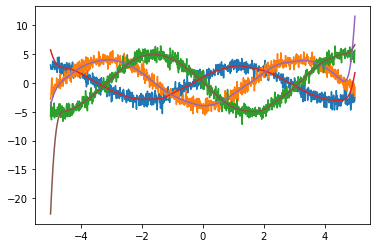

In [14]:
plt.plot(signal.domain, signal.values)
plt.plot(filtered_signal.domain, filtered_signal.values)
# TODO smooth interpolation

In [15]:
from dreye.core import LogPhotoreceptor, \
    RelativeOpsinSensitivity, Spectrum, Domain
from scipy.stats import norm

In [16]:
wl = np.arange(300, 600)
s = norm.pdf(wl, 450, 10)
s /= np.sum(s)
s_noise = s + np.random.normal(0, 0.001, size=s.shape)

In [17]:
opsin_noise = RelativeOpsinSensitivity(
    s_noise, 
    domain=wl, 
    smoothing_method='savgol', 
    smoothing_window=15, 
    smoothing_args={'polyorder':2}
)

opsin = RelativeOpsinSensitivity(
    s, 
    domain=wl, 
    smoothing_method='savgol', 
    smoothing_window=15, 
    smoothing_args={'polyorder':2}
)

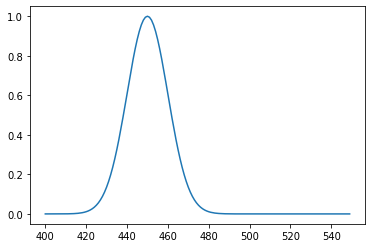

In [18]:
opsin_interp = opsin(
    Domain(np.arange(400, 550), units='nm')
)
plt.plot(opsin_interp.domain, opsin_interp)

In [19]:
opsin_noise.smoothing_method

'savgol'

In [20]:
opsin_smooth2 = opsin_noise.smooth

In [21]:
opsin_smooth = opsin_noise.window_filter(
    15, 'savgol', polyorder=2
)

In [22]:
type(opsin_smooth), type(opsin_smooth2)

(dreye.core.spectral_sensitivity.RelativeOpsinSensitivity,
 dreye.core.spectral_sensitivity.RelativeOpsinSensitivity)

In [23]:
from scipy.signal import savgol_filter

In [24]:
ssmooth = savgol_filter(s_noise, 15, 2)

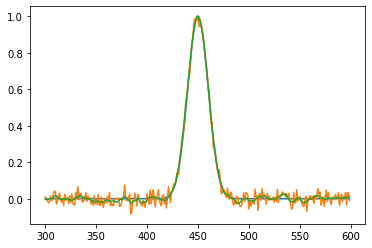

In [25]:
plt.plot(opsin.wavelengths, opsin)
plt.plot(opsin_noise.wavelengths, opsin_noise)
plt.plot(opsin_smooth.wavelengths, opsin_smooth)

In [26]:
pr = LogPhotoreceptor(opsin_interp)
pr2 = LogPhotoreceptor(opsin_smooth)

In [27]:
ill = norm.pdf(wl, 400, 80)
bg = np.ones(wl.shape)

In [28]:
illuminant = Spectrum(
    ill, 
    domain=wl
)
background = Spectrum(
    bg, 
    domain=wl
)

In [29]:
np.log(np.sum(ill*s)/np.sum(bg*s))

-5.5010249534542295

In [30]:
pr.excitation(
    illuminant, 
    background=background, 
    units=False
)

-5.501025001659692

In [31]:
pr2.excitation(
    illuminant, 
    background=background, 
    units=False
)

-5.509386863952244

In [32]:
np.log(np.sum(ill*s_noise)/np.sum(bg*s_noise))

-5.509574004578909

In [33]:
type(illuminant)

dreye.core.spectrum.Spectrum

In [34]:
illuminant.normalized_spectrum

[0.00257132 0.00261161 0.00265212 0.00269283 0.00273374 0.00277484 0.00281611 0.00285756 0.00289916 0.0029409  0.00298279 0.00302479 0.00306691 0.00310913 0.00315143 0.00319382 0.00323627 0.00327877 0.0033213  0.00336387 0.00340645 0.00344903 0.00349159 0.00353413 0.00357663 0.00361907 0.00366144 0.00370374 0.00374593 0.00378801 0.00382997 0.00387179 0.00391345 0.00395495 0.00399625 0.00403736 0.00407826 0.00411892 0.00415934 0.00419951 0.00423939 0.00427899 0.00431828 0.00435725 0.00439589 0.00443418 0.0044721  0.00450964 0.00454678 0.00458352 0.00461983 0.0046557  0.00469111 0.00472606 0.00476052 0.00479449 0.00482794 0.00486087 0.00489325 0.00492509 0.00495635 0.00498704 0.00501713 0.00504661 0.00507547 0.00510371 0.00513129 0.00515822 0.00518448 0.00521006 0.00523495 0.00525914 0.00528261 0.00530536 0.00532737 0.00534864 0.00536915 0.0053889 0.00540788 0.00542608 0.00544349 0.0054601  0.0054759  0.0054909 0.00550507 0.00551842 0.00553094 0.00554262 0.00555345 0.00556344 0.00557258 0.00558085 0.00558827 0.00559482 0.00560051 0.00560532 0.00560927 0.00561234 0.00561453 0.00561584 0.00561628 0.00561584 0.00561453 0.00561234 0.00560927 0.00560532 0.00560051 0.00559482 0.00558827 0.00558085 0.00557258 0.00556344 0.00555345 0.00554262 0.00553094 0.00551842 0.00550507 0.0054909  0.0054759  0.0054601 0.00544349 0.00542608 0.00540788 0.0053889  0.00536915 0.00534864 0.00532737 0.00530536 0.00528261 0.00525914 0.00523495 0.00521006 0.00518448 0.00515822 0.00513129 0.00510371 0.00507547 0.00504661 0.00501713 0.00498704 0.00495635 0.00492509 0.00489325 0.00486087 0.00482794 0.00479449 0.00476052 0.00472606 0.00469111 0.0046557 0.00461983 0.00458352 0.00454678 0.00450964 0.0044721  0.00443418 0.00439589 0.00435725 0.00431828 0.00427899 0.00423939 0.00419951 0.00415934 0.00411892 0.00407826 0.00403736 0.00399625 0.00395495 0.00391345 0.00387179 0.00382997 0.00378801 0.00374593 0.00370374 0.00366144 0.00361907 0.00357663 0.00353413 0.00349159 0.00344903 0.00340645 0.00336387 0.0033213  0.00327877 0.00323627 0.00319382 0.00315143 0.00310913 0.00306691 0.00302479 0.00298279 0.0029409 0.00289916 0.00285756 0.00281611 0.00277484 0.00273374 0.00269283 0.00265212 0.00261161 0.00257132 0.00253126 0.00249143 0.00245185 0.00241252 0.00237344 0.00233464 0.00229611 0.00225787 0.00221991 0.00218225 0.0021449  0.00210785 0.00207112 0.00203472 0.00199864 0.00196289 0.00192749 0.00189242 0.00185771 0.00182334 0.00178933 0.00175568 0.0017224  0.00168948 0.00165693 0.00162476 0.00159296 0.00156154 0.0015305  0.00149984 0.00146957 0.00143968 0.00141018 0.00138107 0.00135235 0.00132402 0.00129608 0.00126853 0.00124137 0.00121461 0.00118823 0.00116225 0.00113666 0.00111146 0.00108664 0.00106222 0.00103818 0.00101452 0.00099126 0.00096837 0.00094586 0.00092374 0.00090198 0.00088061 0.0008596  0.00083897 0.0008187 0.0007988  0.00077926 0.00076008 0.00074126 0.00072279 0.00070466 0.00068689 0.00066946 0.00065237 0.00063562 0.0006192  0.00060311 0.00058735 0.0005719  0.00055678 0.00054198 0.00052748 0.00051329 0.00049941 0.00048582 0.00047254 0.00045954 0.00044683 0.0004344 0.00042226 0.00041039 0.00039879 0.00038745 0.00037639 0.00036558 0.00035502 0.00034472 0.00033466 0.00032484 0.00031527 0.00030593 0.00029682 0.00028793 0.00027927 0.00027082 0.00026259 0.00025458] / nanometer

In [36]:
illph = illuminant.photonflux